<a href="https://colab.research.google.com/github/PietroSchgor/Bayesian-Project/blob/main/Model2_GP3112_order_p.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ProjectBayesianDirectory

Mounted at /gdrive
/gdrive/My Drive/ProjectBayesianDirectory


In [3]:
# Install cmdstanpy module
!pip install cmdstanpy
!pip list | grep cmdstanpy

cmdstanpy                          1.2.5


In [4]:
# Install arviz module (With version 2.33.1 you will need a special version of arviz)
!pip install arviz
!pip list | grep arviz

arviz                              0.20.0


In [5]:
# Install cmdstan -- Just for the first time!
from cmdstanpy import install_cmdstan
install_cmdstan()

CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.36.0
Download successful, file: /tmp/tmpvuyad_p9
Extracting distribution


DEBUG:cmdstanpy:cmd: make build -j1
cwd: None


Unpacked download as cmdstan-2.36.0
Building version cmdstan-2.36.0, may take several minutes, depending on your system.


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Installed cmdstan-2.36.0
Test model compilation


True

In [6]:
from cmdstanpy import cmdstan_path
cmdstan_path()

'/root/.cmdstan/cmdstan-2.36.0'

In [7]:
# Create folder to store .stan files
import os
if not os.path.exists("./stan"):
    os.mkdir("./stan")

# Import modules
import numpy as np
import arviz as az
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Import functions
from cmdstanpy import CmdStanModel
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

# Upload data




In [8]:
y = pd.read_csv('TremorProb_1.csv')
print(y.head())

   -0.620922462937449  -0.668689165888089  -0.409872821087173  \
0           -0.620922           -0.668689           -0.409873   
1           -0.620922           -0.668689           -0.409873   
2           -0.620922           -0.668689           -0.409873   
3           -0.620922           -0.668689           -0.409873   
4           -0.620922           -0.668689           -0.409873   

   -0.46836544467914  -0.672098617117627  -0.568842619576277  \
0          -0.468365           -0.672099           -0.568843   
1          -0.468365           -0.672099           -0.568843   
2          -0.468365           -0.672099           -0.568843   
3          -0.468365           -0.672099           -0.568843   
4          -0.468365           -0.672099           -0.568843   

   -0.478079682575386  -0.417804016451204  -0.758451513461839  \
0            -0.47808           -0.417804           -0.758452   
1            -0.47808           -0.417804           -0.758452   
2            -0.47808        

In [9]:
N = y.shape[0]
d = y.shape[1]
print("Dimension is", N)
print("Sample is", d)

Dimension is 287
Sample is 15


In [10]:
x = np.linspace(0,1,N)

In [11]:
y = np.array(np.transpose(y))

In [12]:
y

array([[-0.62092246, -0.62092246, -0.62092246, ..., -0.62092246,
        -0.62092246, -0.62092246],
       [-0.66868917, -0.66868917, -0.66868917, ...,  0.59905107,
         0.25255206,  0.12731979],
       [-0.40987282, -0.40987282, -0.40987282, ..., -0.31308653,
        -0.35717438, -0.40126223],
       ...,
       [-0.4982822 , -0.4982822 , -0.4982822 , ..., -0.4982822 ,
        -0.4982822 , -0.4982822 ],
       [-0.6061394 , -0.6061394 , -0.6061394 , ..., -0.3327095 ,
        -0.43775713, -0.59682581],
       [-0.42226794, -0.42226794, -0.42226794, ..., -0.42226794,
        -0.42226794, -0.42226794]])

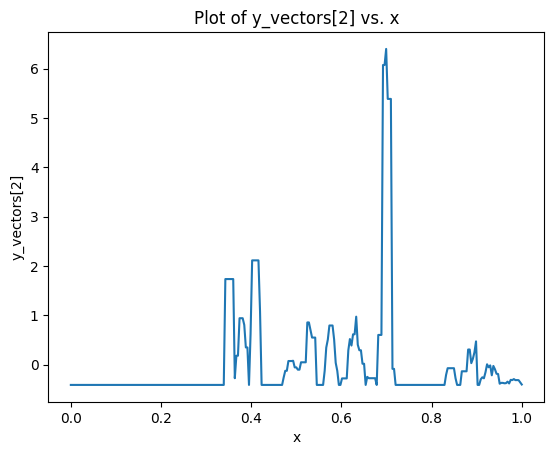

In [13]:
plt.plot(x, y[2,:])
plt.xlabel("x")
plt.ylabel("y_vectors[2]")
plt.title("Plot of y_vectors[2] vs. x")
plt.show()

# Current Model
This is the model we are going to use
$$
   \mathbf{y}_{t}(s) = (1-\beta) \mu(s) + \beta \mathbf{y}_{t-1}+ ϵ \in \mathbb{R}^{N}
$$

\\
Let $\mathbf{y}_{t}(s) = (Y(\mathbf{s}, t), \dots, Y(\mathbf{s}, t)) \in \mathbb{R}^{N}$. The hierarchical bayesian model is as follows

\\

\begin{aligned}
    \mathbf{y_t} \mid \beta, \mathbf{\mu}, \boldsymbol{\tau^2}, \mathbf{y_{t-1}} &\sim \text{multivariate normal}((1-\beta) \mu + \beta \mathbf{y}_{t-1}, diag(\boldsymbol{\tau^2}))\\
    \mu &\sim \text{multivariate normal}(0,\sigma^2 \mathbf{A}(\rho))\\
    %\rho &\sim \text{InvGamma}(5, 5) \\
    \sigma &\sim \text{InvGamma}(1, 2) \\
    %\alpha &\sim \text{normal}(0, 1) \\
    \tau_s &\overset{\underset{\mathrm{i.i.d}}{}}{\sim} \text{InvGamma}(1, 2)  \    s=1,2...,N controllare squared o no\\   
    \beta &\sim \text{Beta}(1.5,1.5)
\end{aligned}

And
\begin{aligned}
 \mathbf{A}(\rho)_{ij} &= \frac{1}{(1-\rho^2)} \rho^{\lvert i-j \rvert}
 \end{aligned}

In [16]:
# Useful functions for the spatio-temporal model
spt_tools = \
"""
// Computes Temporal covariance kernel
matrix cov_time(int T, real rho_t) {
    matrix[T,T] cov;
    for (i in 1:T) {
        for(j in i:T) {
            cov[i,j] = rho_t^abs(i-j);
            cov[j,i] = cov[i,j];
        }
    }
    return (1/(1-rho_t^2)) * cov;
}

// Computes kronecker product between vectors
vector kron_prod(vector A, vector B){
    int N = size(A);
    int P = size(B);
    vector[N*P] kron;
    for (i in 1:N) {
        kron[((i-1)*P+1):i*P] = A[i] * B;
    }
    return kron;
}

// Computes the media for the i-day
vector media_construction (int p, int i, array[] vector Y, vector mu, vector phi){
    int N = size(mu);
    vector[N] media = rep_vector(0, N);
    if (i <= p) {
        // Caso per i primi `p` giorni
        vector[i] effective_phi = phi[1:i] / sum(phi[1:i]);
        media += effective_phi[1] * mu;
        for (lag in 1:(i - 1)) {
            media += effective_phi[lag + 1] * Y[i - lag];
        }
    } else {
        media += phi[1] * mu;
        for (lag in 1:p) {
            media += phi[lag + 1] * Y[i - lag];
        }
    }
    return media;
}
"""

# Write functions to file
stan_file = "stan/spt-tools.stan"
with open(stan_file, "w") as f:
    print(spt_tools, file=f)

In [15]:
#ordine 2
synt4_fitGP_ML = """
        functions {
            #include "spt-tools.stan"
        }

        data {
          int<lower=1> d;
          int<lower=1> N;
          int<lower=1> x;     // number of time intervals
          array[d] vector[N] Y; // previous was: matrix[N,d] y;
          real<lower=0> rho;  // time innovation coefficient
          vector<lower=0>[3] alpha;
        }

        transformed data {
          // Temporal covariance matrix
          matrix[N,N] Ht = cov_time(x, rho);

          // Autoregressive vector
          array[d] vector[N] y_n_1;
          array[d] vector[N] y_n_2;
          y_n_1[1] = rep_vector(0,N);
          y_n_2[1] = rep_vector(0,N);
          y_n_1[2] = Y[1];
          y_n_2[2] = rep_vector(0,N);
          for (j in 3:d) {
            y_n_1[j] = Y[j - 1];
            y_n_2[j] = Y[j - 2];
          }

        }

        parameters {
          real<lower=0> sigmat;
          vector<lower=0>[N] tau;
          vector[N] mu;
          simplex[3] mario;

        }

        transformed parameters {

            // Mean vector
            //vector[N] media = mario[1]*mu + mario[2]*y_n_1+ mario[3]*y_n_2;

            // Temporal Covariance Matrix
            matrix[N,N] Sigma_t = sigmat * sigmat * Ht;
            matrix[N,N] Lalpha = cholesky_decompose(Sigma_t);
        }

        model {
          // Likelihood
          for (i in 1:d) {
            vector[N] media = mario[1]*mu + mario[2]*y_n_1[i]+ mario[3]*y_n_2[i];
            Y[i][1:N] ~ normal(media[1:N], tau[1:N]);
          }
          // in case previous don't work Y_vect[1:N*d] ~ normal(media[1:N*d], tau_kro[1:N*d]);

          //Priors
          mu ~ multi_normal_cholesky(rep_vector(0,N), Lalpha);
          sigmat ~ inv_gamma(2, 1);
          for (n in 1:N) {
            tau[n] ~ inv_gamma(2, 1);
           }

          mario ~ dirichlet(alpha);
        }

"""
# Write model to file
stan_file = "./stan/synt5GP_fitML.stan"
with open(stan_file, "w") as f:
    print(synt4_fitGP_ML, file=f)

# Compile stan model
stan_model = CmdStanModel(stan_file=stan_file)

09:50:04 - cmdstanpy - INFO - compiling stan file /tmp/tmprjl253w7/tmpqb80l0z6.stan to exe file /gdrive/My Drive/ProjectBayesianDirectory/stan/synt5GP_fitML
INFO:cmdstanpy:compiling stan file /tmp/tmprjl253w7/tmpqb80l0z6.stan to exe file /gdrive/My Drive/ProjectBayesianDirectory/stan/synt5GP_fitML
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=synt5GP_fitML.stan STANCFLAGS+=--include-paths=/gdrive/My\ Drive/ProjectBayesianDirectory/stan /tmp/tmprjl253w7/tmpqb80l0z6
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=synt5GP_fitML.stan --include-paths=/gdrive/My\ Drive/ProjectBayesianDirectory/stan --o=/tmp/tmprjl253w7/tmpqb80l0z6.hpp /tmp/tmprjl253w7/tmpqb80l0z6.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.

In [17]:
#ordine p (input)
synt4_fitGP_ML = """
        functions {
            #include "spt-tools.stan"
        }

        data {
          int<lower=1> d;
          int<lower=1> N;
          int<lower=1> x;         // number of time intervals
          array[d] vector[N] Y;   // previous was: matrix[N,d] y;
          real<lower=0> rho;      // time innovation coefficient
          int<lower=1> p;
          vector<lower=0>[p+1] alpha;
        }

        transformed data {
          // Temporal covariance matrix
          matrix[N,N] Ht = cov_time(x, rho);
        }

        parameters {
          real<lower=0> sigmat;
          vector<lower=0>[N] tau;
          vector[N] mu;
          simplex[3] phi;
        }

        transformed parameters {
            matrix[N,N] Sigma_t = sigmat * sigmat * Ht;
            matrix[N,N] Lalpha = cholesky_decompose(Sigma_t);
        }

        model {
          // Likelihood
          for (i in 1:d) {
            vector[N] media = media_construction(p, i, Y, mu, phi);
            Y[i][1:N] ~ normal(media[1:N], tau[1:N]);
          }

          //Priors
          mu ~ multi_normal_cholesky(rep_vector(0,N), Lalpha);
          sigmat ~ inv_gamma(2, 1);
          for (n in 1:N) {
            tau[n] ~ inv_gamma(2, 1);
           }
          phi ~ dirichlet(alpha);
        }

"""
# Write model to file
stan_file = "./stan/synt5GP_fitML.stan"
with open(stan_file, "w") as f:
    print(synt4_fitGP_ML, file=f)

# Compile stan model
stan_model = CmdStanModel(stan_file=stan_file)

DEBUG:cmdstanpy:Removing /gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML
12:09:34 - cmdstanpy - INFO - compiling stan file /gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML.stan to exe file /gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML
INFO:cmdstanpy:compiling stan file /gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML.stan to exe file /gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=synt5GP_fitML.stan STANCFLAGS+=--include-paths=/gdrive/MyDrive/ProjectBayesianDirectory/stan /gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=synt5GP_fitML.stan --include-paths=/gdrive/MyDrive/ProjectBayesianDirectory/stan --o=/gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML.hpp /gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML

In [ ]:
#ordine 1
synt4_fitGP_ML = """
        functions {
            #include "spt-tools.stan"
        }

        data {
          int<lower=1> d;
          int<lower=1> N;
          int<lower=1> x;     // number of time intervals
          array[d] vector[N] Y; // previous was: matrix[N,d] y;
          real<lower=0> rho;  // time innovation coefficient
        }

        transformed data {
          // Temporal covariance matrix
          matrix[N,N] Ht = cov_time(x, rho);

          // Autoregressive vector
          array[d] vector[N] y_n_1;
          y_n_1[1] = rep_vector(0,N);
          for (j in 2:d) {
            y_n_1[j] = Y[j - 1];
          }
        }

        parameters {
          real<lower=0> sigmat;
          vector<lower=0>[N] tau;
          real<lower=0> beta;
          vector[N] mu;

        }

        transformed parameters {
            // Mean vector
            //vector[N] media = (1-beta)*mu + beta*y_n_1;

            // Temporal Covariance Matrix
            matrix[N,N] Sigma_t = sigmat * sigmat * Ht;
            matrix[N,N] Lalpha = cholesky_decompose(Sigma_t);
        }

        model {
          // Likelihood
          for (i in 1:d) {
            vector[N] media = (1 - beta) * mu + beta * y_n_1[i];
            Y[i][1:N] ~ normal(media[1:N], tau[1:N]);
          }
          // in case previous don't work Y_vect[1:N*d] ~ normal(media[1:N*d], tau_kro[1:N*d]);

          //Priors
          mu ~ multi_normal_cholesky(rep_vector(0,N), Lalpha);
          sigmat ~ inv_gamma(2, 1);
          tau ~ inv_gamma(2, 1);
          beta ~ beta(1.5,1.5);
        }

"""
# Write model to file
stan_file = "./stan/synt5GP_fitML.stan"
with open(stan_file, "w") as f:
    print(synt4_fitGP_ML, file=f)

# Compile stan model
stan_model = CmdStanModel(stan_file=stan_file)

16:27:39 - cmdstanpy - INFO - compiling stan file /gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML.stan to exe file /gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML
INFO:cmdstanpy:compiling stan file /gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML.stan to exe file /gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=synt5GP_fitML.stan STANCFLAGS+=--include-paths=/gdrive/MyDrive/ProjectBayesianDirectory/stan /gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML
cwd: /root/.cmdstan/cmdstan-2.36.0


KeyboardInterrupt: 

In [16]:
y.shape

(15, 287)

In [17]:
y0 = y[0,:] + np.random.normal(0,0.1,N)

In [18]:
y0.shape

(287,)

In [18]:
# Prepare data list for stan
input_data = {
    "d": d,
    "N": N,
    "x": 287,
    "Y": y,
    "rho": 0.3,
    "p": 2,
    "alpha" : [1.5,1.5,1.5]
}
#specify with the same names you put in data!

# Run the sampler
stan_fit = stan_model.sample(data=input_data, chains=4, parallel_chains=4,
                             iter_warmup=300, iter_sampling=1000)

# Convert chain to arviz format
cmdstanpy_data = az.from_cmdstanpy(stan_fit)

DEBUG:cmdstanpy:cmd: /gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvm2j874p/zhllkktz.json
12:10:59 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML', 'id=1', 'random', 'seed=17395', 'data', 'file=/tmp/tmpvm2j874p/zhllkktz.json', 'output', 'file=/tmp/tmpvm2j874p/synt5GP_fitMLyv0r59ia/synt5GP_fitML-20241231121100_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=300', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML', 'id=3', 'random', 'seed=17395', 'data', 'file=/tmp/tmpvm2j874p/zhllkktz.json', 'output', 'file=/tmp/tmpvm2j874p/synt5GP_fitMLyv0r59ia/synt5GP_fitML-20241231121100_3.csv', 'method=sample', 'num_samples=1000', 'num_warmup=300', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:CmdStan args: ['/gdrive/MyDrive/ProjectBayesianDirectory

12:37:50 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/gdrive/MyDrive/ProjectBayesianDirectory/stan/synt5GP_fitML', 'id=1', 'random', 'seed=17395', 'data', 'file=/tmp/tmpvm2j874p/zhllkktz.json', 'output', 'file=/tmp/tmpvm2j874p/synt5GP_fitMLyv0r59ia/synt5GP_fitML-20241231121100_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=300', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpvm2j874p/synt5GP_fitMLyv0r59ia/synt5GP_fitML-20241231121100_1.csv
 console_msgs (if any):
	/tmp/tmpvm2j874p/synt5GP_fitMLyv0r59ia/synt5GP_fitML-20241231121100_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 300
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Defa

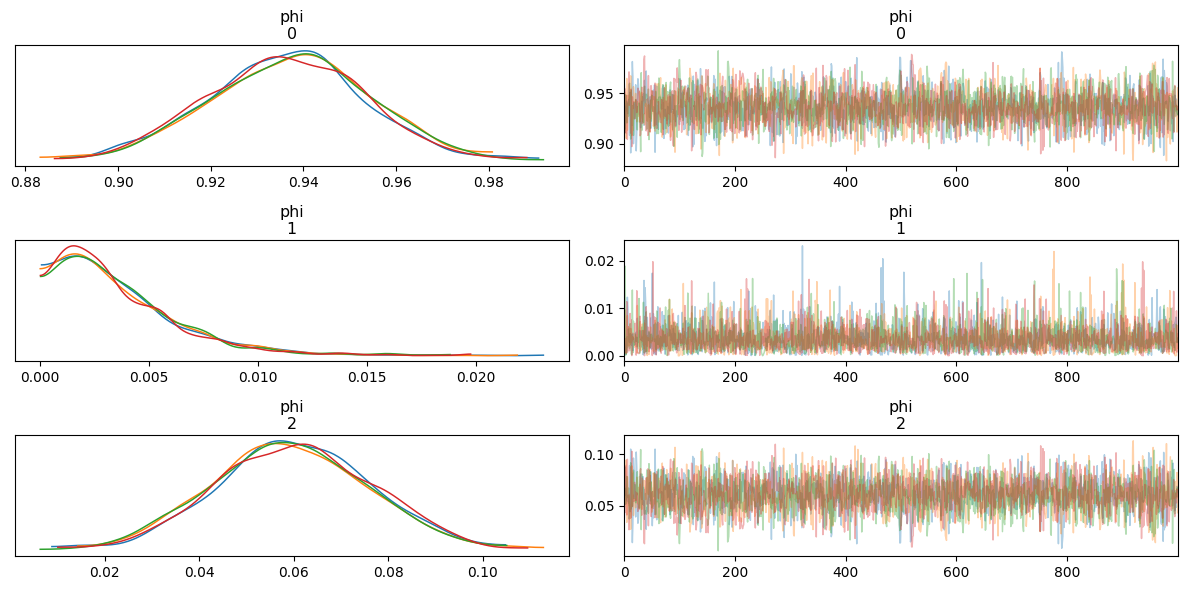

In [20]:
# az.plot_trace(cmdstanpy_data['posterior']['beta'], compact=False)
az.plot_trace(cmdstanpy_data['posterior']['phi'], compact=False)
plt.tight_layout()
plt.show()

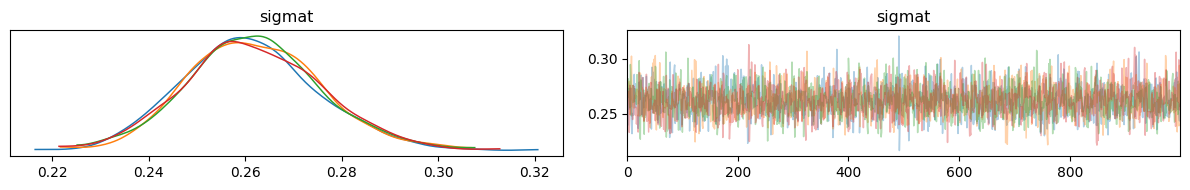

In [21]:
az.plot_trace(cmdstanpy_data['posterior']['sigmat'], compact=False)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (287), generating only 20 plots
  warnings.warn(


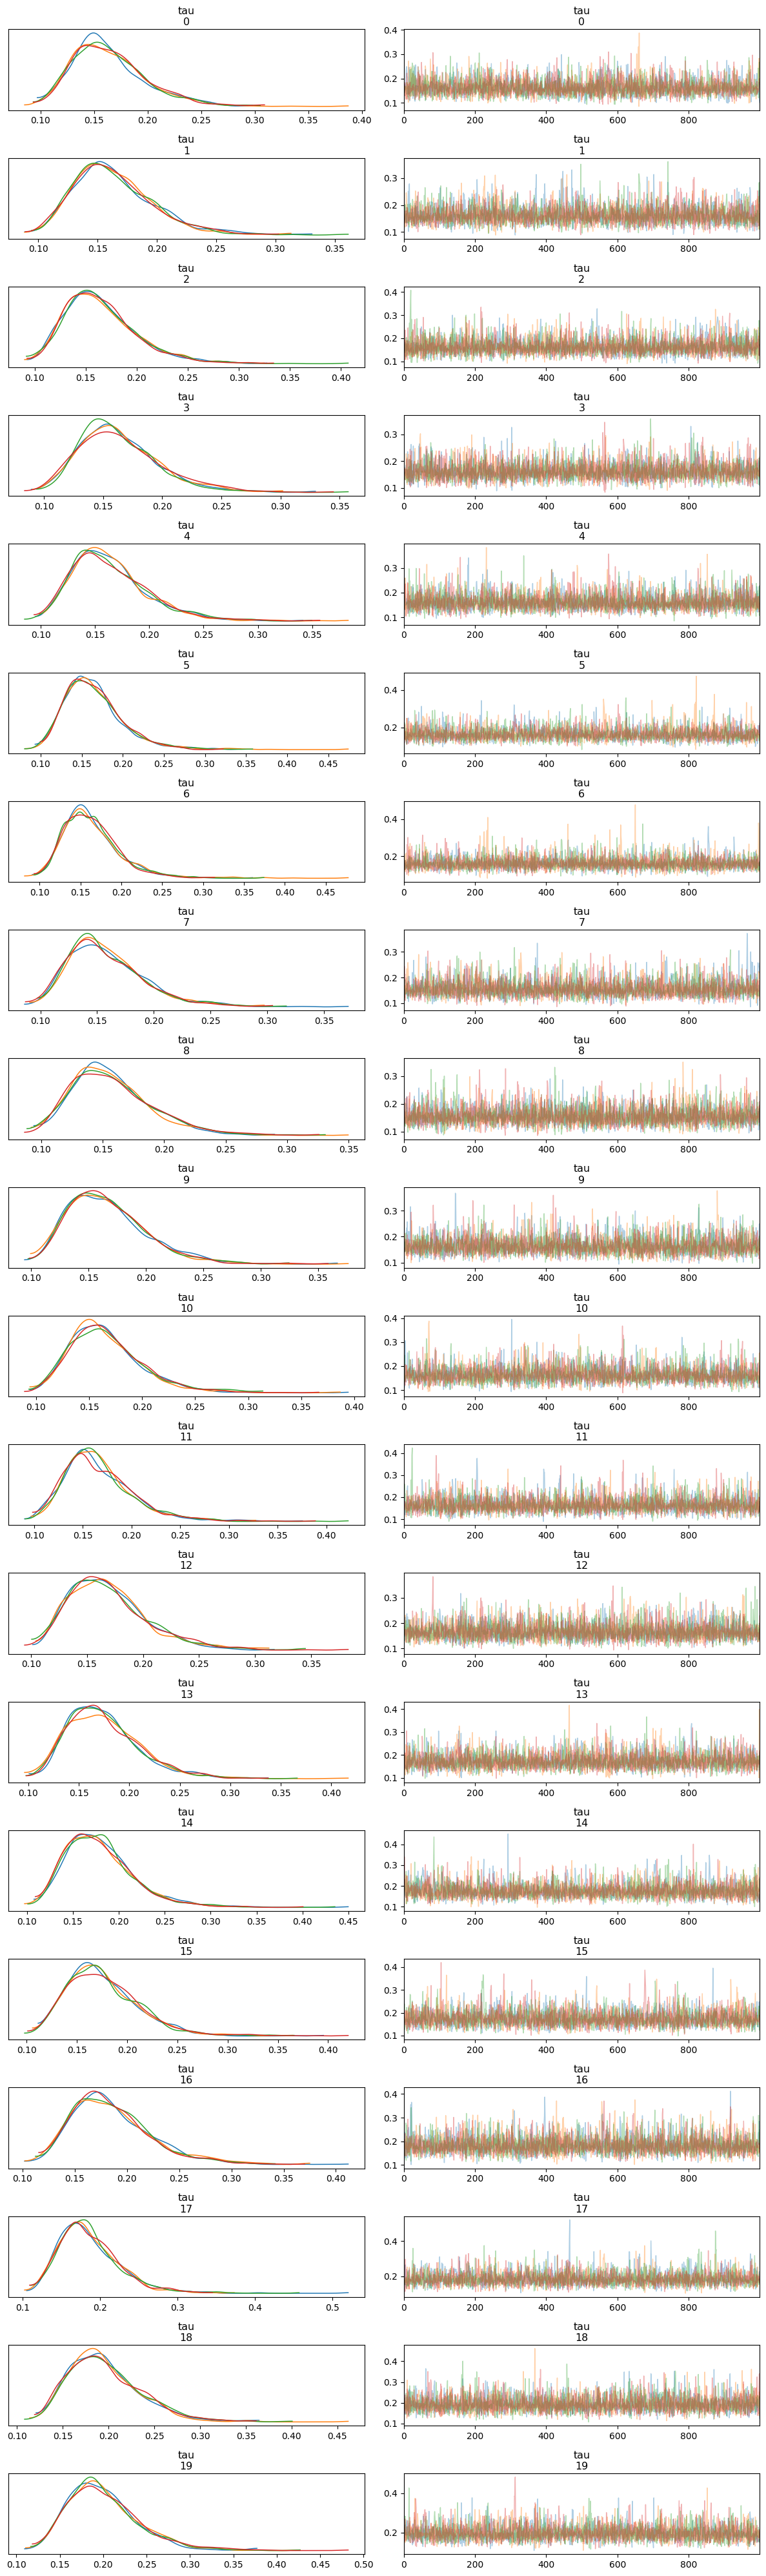

In [22]:
az.plot_trace(cmdstanpy_data['posterior']['tau'], compact=False)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (287), generating only 20 plots
  warnings.warn(


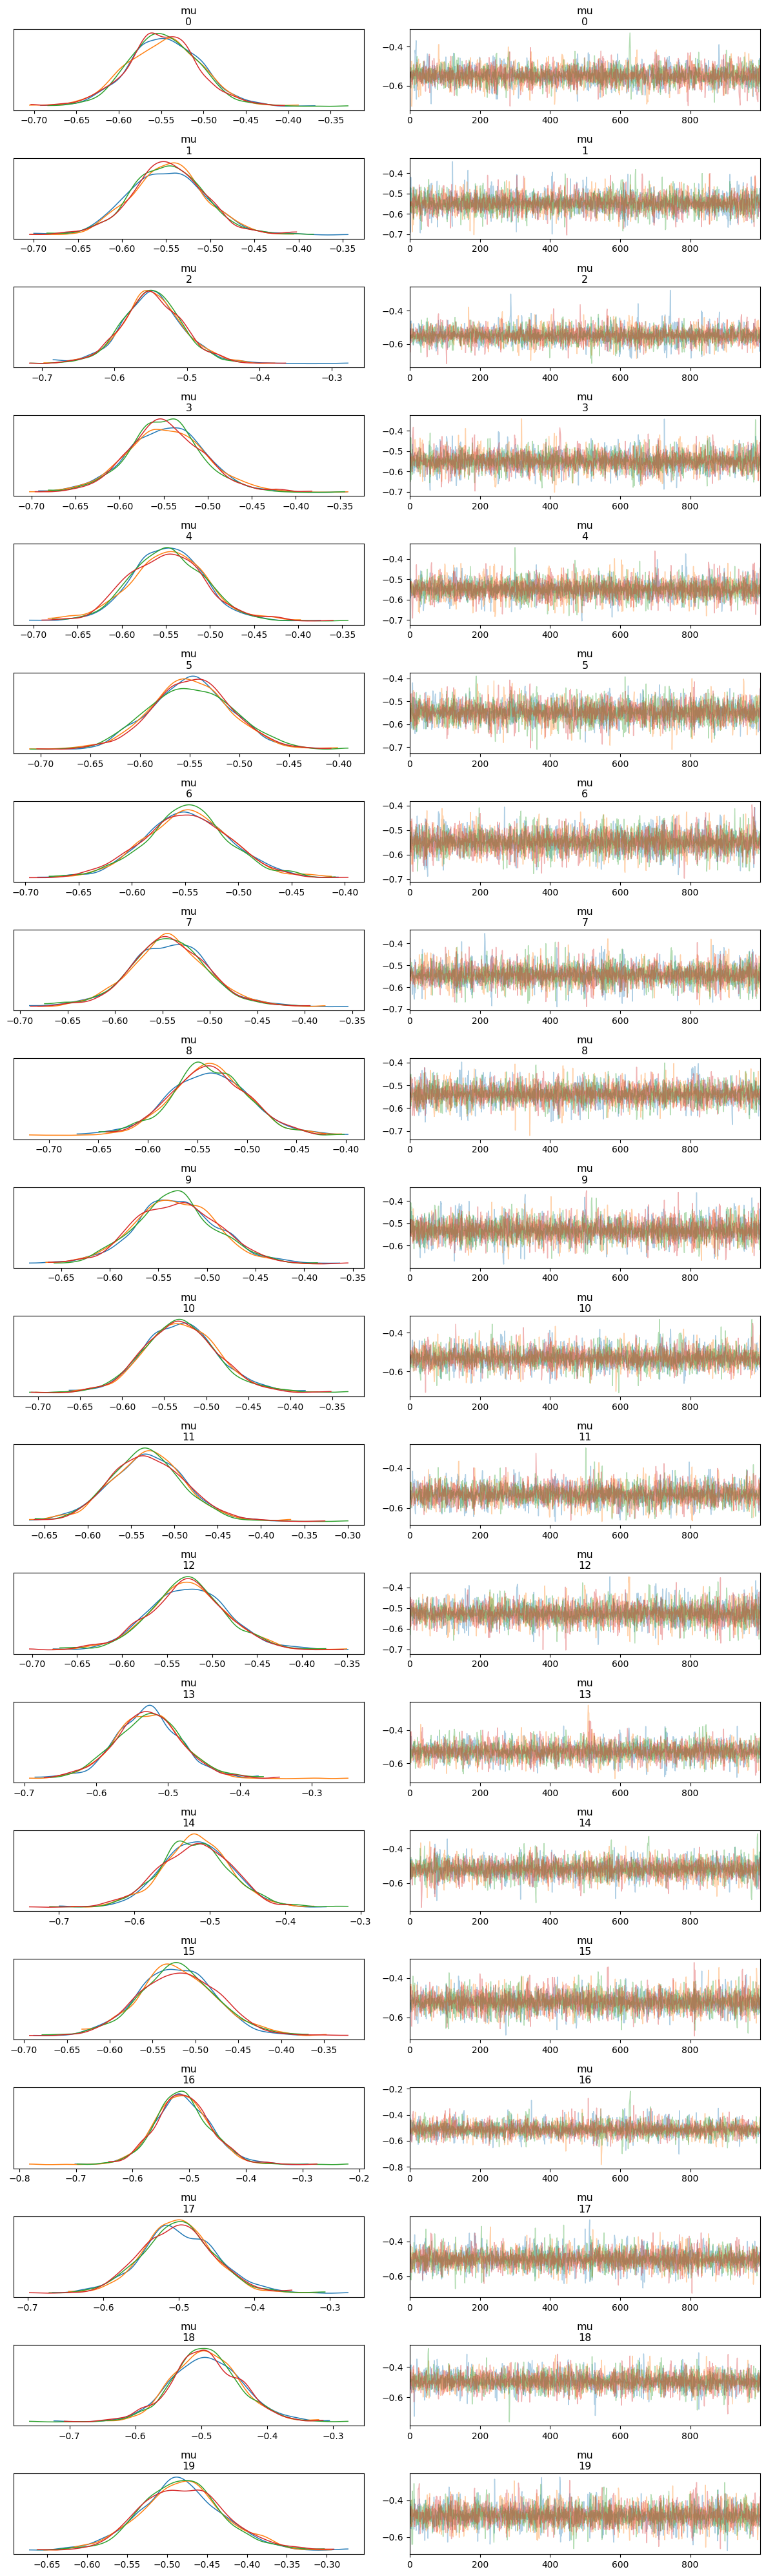

In [ ]:
az.plot_trace(cmdstanpy_data['posterior']['mu'], compact=False)
plt.tight_layout()
plt.show()

In [74]:
#betas = cmdstanpy_data['posterior']['beta'][3]
taus = cmdstanpy_data['posterior']['tau'][3]
mus = cmdstanpy_data['posterior']['mu'][3]
#sigmas = cmdstanpy_data['posterior']['sigma'][3]
#beta = betas.mean().item() # convert to float
tau = taus.mean().item() # convert to float
mu = mus.mean().item() # convert to float
#sigma = sigmas.mean().item() # convert to float

In [ ]:
mu = np.mean(mus, axis=0)

In [ ]:
mu

<xarray.DataArray 'mu' (mu_dim_0: 287)> Size: 2kB
array([-0.5493044 , -0.54778238, -0.54705787, -0.54768675, -0.54867823,
       -0.54719958, -0.54907138, -0.54230552, -0.53786166, -0.53095011,
       -0.53056844, -0.52970258, -0.52808245, -0.52758305, -0.52149264,
       -0.51832985, -0.50934996, -0.50237787, -0.49416172, -0.47881325,
       -0.47162846, -0.41992   , -0.39105218, -0.3961109 , -0.40809137,
       -0.42322743, -0.43849691, -0.46608314, -0.45728563, -0.42987611,
       -0.42273518, -0.42208719, -0.42211178, -0.43649421, -0.47364651,
       -0.49603323, -0.48692102, -0.46861664, -0.46626895, -0.47937746,
       -0.4775036 , -0.48714005, -0.48521002, -0.49989024, -0.50355344,
       -0.49770922, -0.48695079, -0.48265555, -0.44184652, -0.42602223,
       -0.4189372 , -0.42513778, -0.44912197, -0.43987322, -0.48300539,
       -0.40743398, -0.38862739, -0.39039488, -0.34696287, -0.33782493,
       -0.36730147, -0.46149291, -0.48419871, -0.45132557, -0.48245222,
       -0.46659359, -0.33735091, -0.26991727, -0.21054994, -0.18557489,
       -0.15052415, -0.15272637, -0.22786118, -0.22357563, -0.1663703 ,
       -0.19233298, -0.16396896, -0.11806442, -0.05793576, -0.00308373,
       -0.01711376,  0.01146634, -0.03436891, -0.18140525, -0.27208654,
       -0.29811545, -0.25986283, -0.19550166, -0.08878573, -0.05203234,
        0.01163546,  0.07474582,  0.1008093 ,  0.17384782,  0.18739445,
        0.18503731,  0.21502934,  0.24317462,  0.26567663,  0.18527765,
...
        0.04281363,  0.1379758 ,  0.18540751,  0.32975023,  0.36357234,
        0.38491843,  0.35211647,  0.30967707,  0.30242303,  0.24847696,
        0.19861155,  0.20145457,  0.21387178,  0.20398762,  0.06415954,
        0.03225682,  0.02657995, -0.05979273, -0.29778596, -0.09260023,
        0.0069862 ,  0.0614671 ,  0.0658479 ,  0.04223886,  0.13598809,
        0.08302196,  0.09337921,  0.09274047,  0.03897836,  0.14875391,
        0.18408062,  0.25539964,  0.24063178,  0.26576748,  0.2645062 ,
        0.22260652,  0.156203  ,  0.0524505 ,  0.09097119,  0.09895477,
        0.20495297,  0.26146018,  0.22321627,  0.28274633,  0.3050347 ,
        0.32361217,  0.31317062,  0.31425401,  0.31897174,  0.33637299,
        0.16771731,  0.02887197, -0.02656809, -0.07249562,  0.04247032,
        0.06797608,  0.15554486,  0.17297838,  0.19363763,  0.19850726,
        0.12356522,  0.00686007, -0.03486189, -0.0498353 , -0.11569083,
       -0.11024206, -0.0720862 ,  0.10447853,  0.10701567,  0.18861983,
        0.19088838,  0.13865562,  0.16345968,  0.01695349, -0.0124166 ,
       -0.13821618, -0.16616214, -0.27738128, -0.2472982 , -0.21768558,
       -0.20413736, -0.17285401, -0.2235085 , -0.24779198, -0.22603125,
       -0.2685306 , -0.299838  , -0.37542805, -0.33606562, -0.29094993,
       -0.23242627, -0.21368704, -0.23640813, -0.26705566, -0.30174715,
       -0.32449009, -0.42451611])
Coordinates:
    chain     int64 8B 3
  * mu_dim_0  (mu_dim_0) int64 2kB 0 1 2 3 4 5 6 ... 280 281 282 283 284 285 286

In [73]:
# y_sim = beta*y[12,:] + (1-beta)*mu

mu = np.array(np.mean(cmdstanpy_data['posterior']['mu'][3], axis=0))
phi = cmdstanpy_data['posterior']['phi'][3].mean(axis=0)
y_sim = phi[0].item()*mu + phi[1].item()*y[12,:] + phi[2].item()*y[11,:]

In [75]:
tau = np.mean(taus, axis=0)
K = np.diag(tau)

In [76]:
y_draws = np.random.multivariate_normal(y_sim, K, 500)

In [77]:
y_new = np.mean(y_draws, axis=0)

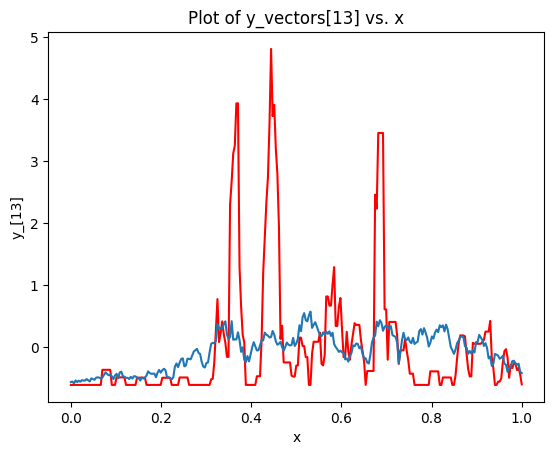

In [78]:
plt.plot(x, y[13,:], color="red")
plt.plot(x, y_new)
plt.xlabel("x")
plt.ylabel("y_[13]")
plt.title("Plot of y_vectors[13] vs. x")
plt.show()

Note: [extension to glm gaussian process](https://mc-stan.org/docs/stan-users-guide/gaussian-processes.html#discrete-outcomes-with-gaussian-processes) (not used in the project but interesting comunque)

Note for the future: [here to make predictions](https://mc-stan.org/docs/stan-users-guide/gaussian-processes.html#discrete-outcomes-with-gaussian-processes)